In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(6,4))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Part 1 - Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

## Read file

In [3]:
#read json file
logins = pd.read_json("/Users/colinechabloz/Desktop/logins.json")

In [4]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [6]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
# Create new column containing only 1 to aggregate over
logins["count"] = 1

In [8]:
logins.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [9]:
#Sort data in chronological order
logins = logins.sort_values(by="login_time").reset_index(drop=True)

In [10]:
logins.head()

,login_time,count
0,1970-01-01 20:12:16,1
1,1970-01-01 20:13:18,1
2,1970-01-01 20:16:10,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:16:37,1


## Aggregate

In [11]:
# Group data by intervals of 15-minute
logins_group = logins.set_index("login_time").resample("15T").sum()

In [12]:
# Function to replace NaN values with 0
def repl_NaN(value):
    if np.isnan(value):
        return 0
    else:
        return value

In [13]:
# Replace NaN values with 0
logins_group = logins_group[["count"]].applymap(func=repl_NaN)

In [14]:
# Make all values as integers
logins_group["count"] = logins_group["count"].astype(int)

In [15]:
logins_group.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [16]:
logins_group.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


The logins are aggregated into 9788 batches of 15 minutes, and a counter tells us how many logins are in each batch. We will now visualize the batches and the associated counts of logins.

## Visualize

### Overall pattern

One hour is split into 4 samples, and one day is therefore split into 4*24 = 96 samples. By definition, one week is 672 samples. 

Let's sse if there is a pattern in the distribution of logins, and even better if there is a cyclical pattern that we can recognize. 

With this first plot, it seems like the period for the cycle is 1 week.

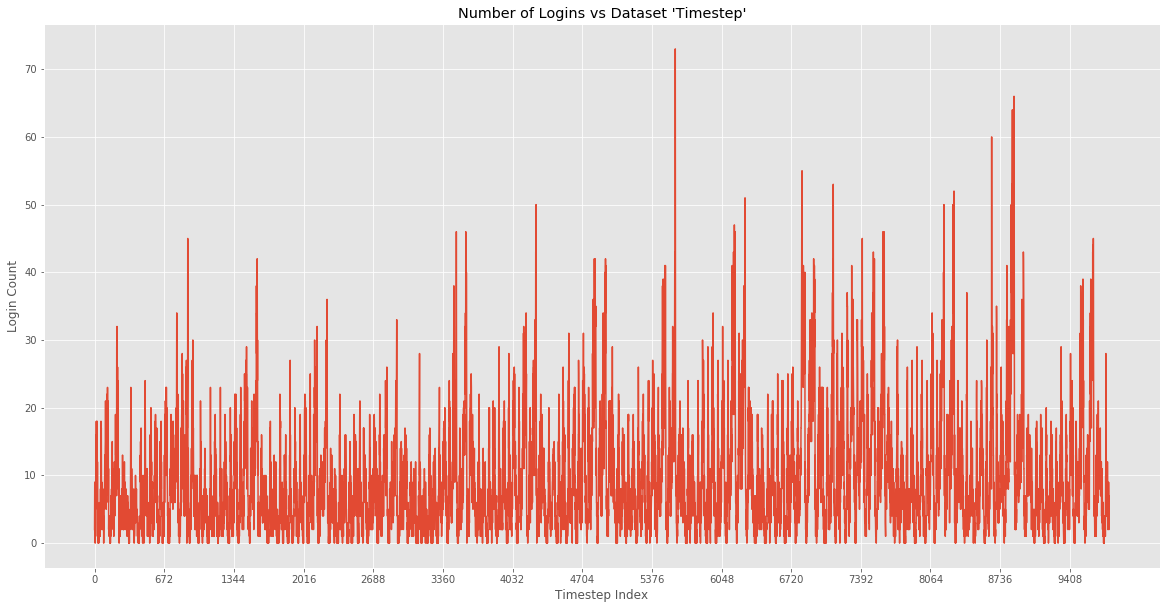

In [17]:
timesteps = logins_group.index.astype(str).values
counts = logins_group["count"].values

plt.figure(figsize=(20,10))
plt.plot(counts)
plt.title("Number of Logins vs Dataset 'Timestep'")
plt.xlabel("Timestep Index")
plt.ylabel("Login Count")
plt.xticks([x for x in range(0,len(counts),672)])
plt.show()

**Observations:** 

1) 1 week cycle

2) January (0 to 2688) and February (2688 to 5376) collect a similar number and pattern of logins

3) March (5376 to 8064) has a peak in its first week

4) April (8064 to max available) has a peak in its second week

### Weekly pattern

Now that we identified a similar cycle of logins each week, let's go in detail into one week to see if there are more specific patterns inside. 

We know that the first available week data is at 8pm, January 1st 1970, and it was (thanks to a google search!) a Thursday. 

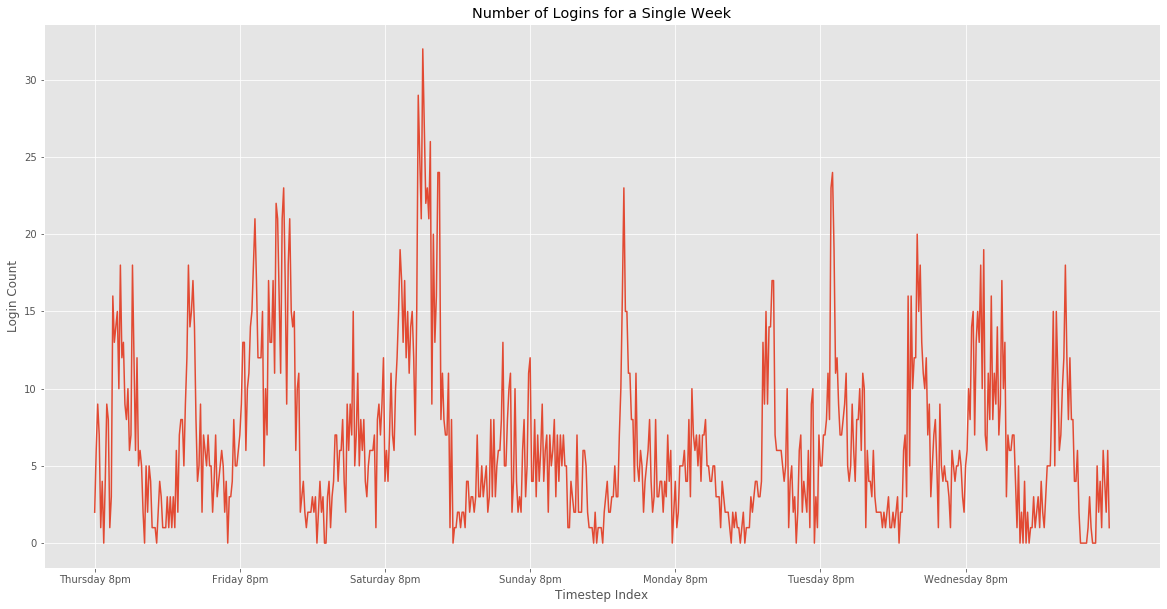

In [18]:
plt.figure(figsize=(20,10))
plt.plot(counts[0:672])
plt.title("Number of Logins for a Single Week")
plt.xlabel("Timestep Index")
plt.ylabel("Login Count")
plt.xticks([x for x in range(0,len(counts[0:672]),96)],
           ("Thursday 8pm","Friday 8pm", "Saturday 8pm", "Sunday 8pm", "Monday 8pm", "Tuesday 8pm", "Wednesday 8pm"))
plt.show()

**Observations:** 

1) Saturday night is a peak in this week

2) Sunday is the day were the least number of logins occured in this week

3) Generally, in a day, there seems to be a peak in te morning and one in the night

### Maximum number of logins overall

Let's look at the maximum number of logins in any 15 minute window. To see exactly at what time we have the most logins.

In [19]:
# Show first 30 most visited hours
print(logins_group["count"].sort_values(ascending=False)[0:30])

login_time
1970-03-01 04:30:00    73
1970-04-04 05:30:00    66
1970-04-04 01:30:00    64
1970-04-04 01:15:00    63
1970-04-01 23:30:00    60
1970-04-04 05:00:00    60
1970-04-04 05:15:00    59
1970-04-04 04:45:00    59
1970-04-04 01:45:00    56
1970-03-13 22:15:00    55
1970-04-04 01:00:00    54
1970-03-17 01:30:00    53
1970-04-04 00:30:00    53
1970-03-29 04:45:00    52
1970-03-08 04:45:00    51
1970-04-03 22:45:00    50
1970-03-29 02:15:00    50
1970-04-04 00:45:00    50
1970-02-15 04:45:00    50
1970-03-28 04:30:00    50
1970-03-01 04:45:00    48
1970-04-04 03:00:00    47
1970-03-07 03:00:00    47
1970-03-08 05:00:00    47
1970-04-03 23:15:00    47
1970-03-07 04:45:00    46
1970-04-04 03:15:00    46
1970-02-07 04:30:00    46
1970-03-22 04:00:00    46
1970-03-22 01:30:00    46
Name: count, dtype: int64


**Observations:**

1) The 15 minute sample containing the most logins are: 
    - first week of March @4.30am
    - first week of April @5.30am
    - first week of April @1.30am
    - first week of April @1.15am
    - first week of April @11.30pm

2) More generally, the peak hours are during the late night (from 10pm) and during the night until early morning (between 4.30am and 5.30am)

# Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

From the point of view of the city managers, a key measure of success of this experiment could be the number of driver partners in each city during the week and during the weekend. The objective is to increase the availability of driver partners according to the day of the week (week vs weekend). 

**2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

<b> a. how you will implement the experiment</b>

<b> Answer a:</b> Monitor which city each driver partner is in at any time and in doing so calculate the added availability of driver partners at a given location for any period in time. 
To do so, a car plate scanner at the 2-way toll would allow us to know in which city a driver would be. 

<b> b. what statistical test(s) you will conduct to verify the significance of the observation </b>

<b> Answer b:</b> A Z hypothesis test could be formulated to test if the reimbursement of the tolls leads to increased availability of driver partners at the location with higher demand.

H0: No difference in the number of driver partners (in a given location with higher demand) between the toll reimbursement case and no toll reimbursement.

H1: Difference in the number of driver partners (in a given location with higher demand) between the toll reimbursement case and no toll reimbursement.

<b> c. how you would interpret the results and provide recommendations to the city operations team along with any caveat </b>

<b> Answer c:</b> Interpreting results is as simple as looking at the figures and the statistical tests. Then it's a question of if the added availability leads to higher revenue of driver partners (in total), or shorter waiting times for passengers (providing that that is the objective of the city operations managers). In that case a further cost-benefit analysis would have to be conducted, with the cost being the reimbursement of all driver partner toll expenditures, and the benefit being added availability/revenue or shorter waiting times. The recommendation would then depend on the above-mentioned process, where if the reimbursement of toll costs is beneficial then we recommend to keep that system, and if not then we revert back to the original way of doing things.

# Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

**We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.**

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. 

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

## Data description
● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

## 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

### Data wrangling and formatting

In [40]:
with open('/Users/colinechabloz/Desktop/ultimate_data_challenge.json') as f:
    data = json.load(f)

ultimate_df = pd.DataFrame(data)
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [41]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [42]:
ultimate_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [43]:
ultimate_df[['last_trip_date','signup_date']].describe()

,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29,2014-01-18
freq,2036,2948


In [44]:
ultimate_df['last_trip_date'][0] # so right now they are strings

'2014-06-17'

In [45]:
#this sequence runs through the dataframe, creates a date six months from the start date, and then checks if the last trip falls
#within a 30 days of that time. Then it ouputs a 1 or 0 to a list of active users.

active_users = []
for i in range(len(ultimate_df)):
    st = pd.Timestamp(ultimate_df['signup_date'][i]) #get start date
    et = st + pd.Timedelta('181D') #6 months later
    at = et - pd.Timedelta('30D') #set point 30 days prior
    if at <= pd.Timestamp(ultimate_df['last_trip_date'][i]) <= et:
        active_users.append([1]) # now that the active condition has been met, set active user to 1
    else:
        active_users.append([0])

In [46]:
df1 = pd.DataFrame(active_users,columns = ['active_users'])

In [47]:
df1['active_users'].value_counts()

0    37802
1    12198
Name: active_users, dtype: int64

In [48]:
12198/50000*100

24.396

Fraction of active users = 24%

### Exploratory Data Analysis

In this section, we will analyze relationships between variables with the objective of understanding what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

#### Continuous Data

AVERAGE DISTANCE vs ACTIVE USERS

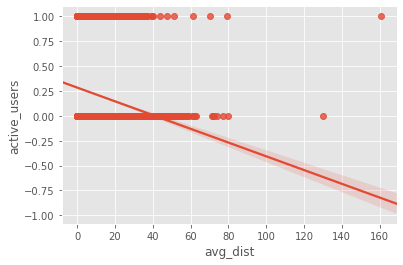

In [84]:
sns.regplot(y=df1['active_users'], x=ultimate_df['avg_dist'], fit_reg = True)

**Observations:** It seems like the longer the average distance, the less likely a user is to be active. 
Someone who is taking a one-time, longer trip may have been longer on average. I will include this feature in my prediction model. 

SURGE PCT vs ACTIVE USERS

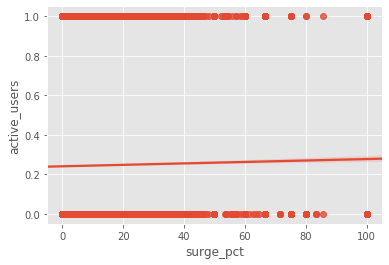

In [50]:
sns.regplot(y=df1['active_users'], x=ultimate_df['surge_pct'], fit_reg = True)

**Observations:** There is almost no correlation between the two variables so I will not include "surge pct" - nor its correlary, "avg surge", in my model.

AVG RATING OF DRIVER vs AVG RATING BY DRIVER

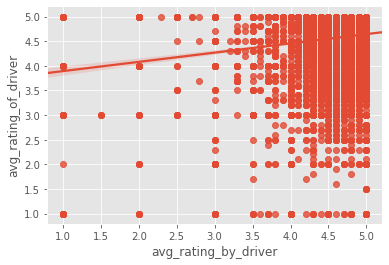

In [51]:
sns.regplot(y=ultimate_df['avg_rating_of_driver'], x=ultimate_df['avg_rating_by_driver'], fit_reg = True)

**Observations:** There is not as strong a correlation between these two variables. I will check each variable indvidually against varible active users.

AVG RATING BY DRIVER vs ACTIVE USERS

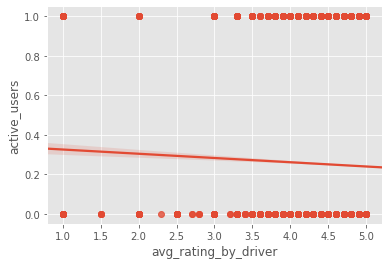

In [52]:
sns.regplot(y=df1['active_users'], x=ultimate_df['avg_rating_by_driver'], fit_reg = True)

AVG RATING OF DRIVER vs ACTIVE USERS

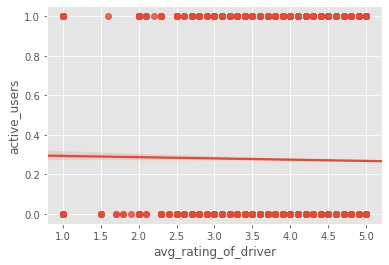

In [53]:
sns.regplot(y=df1['active_users'], x=ultimate_df['avg_rating_of_driver'], fit_reg = True)

**Observations:** "average rating by driver" has a stronger (negative) correlation with "active users" than "average rating of driver". I will inlcude "average rating by driver" but not "average rating of driver". 

WEEKDAY PCT vs ACTIVE USERS

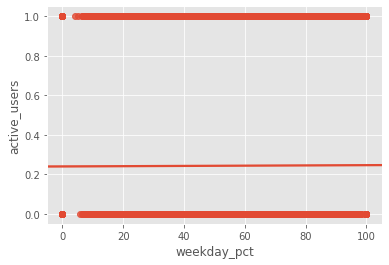

In [54]:
sns.regplot(y=df1['active_users'], x=ultimate_df['weekday_pct'], fit_reg = True)

**Observations:** No correlation

TRIPS IN FIRST 30 DAYS vs ACTIVE USERS

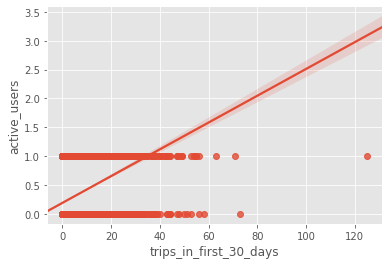

In [55]:
sns.regplot(y=df1['active_users'], x=ultimate_df['trips_in_first_30_days'], fit_reg = True)

**Observations:** Strong positive correlation. I will include "trips in first 30 days" variable in classification model. 

#### Categorical data

In [56]:
df = pd.concat([ultimate_df, df1], axis = 1)

After our correlation analysis above, let's remove the variables that will not be included in the model: 

In [57]:
df = df.drop(['avg_rating_of_driver', 'avg_surge','surge_pct','last_trip_date','signup_date','weekday_pct'], axis = 1)

In [58]:
df.head()

,avg_dist,avg_rating_by_driver,city,phone,trips_in_first_30_days,ultimate_black_user,active_users
0,3.67,5.0,King's Landing,iPhone,4,True,0
1,8.26,5.0,Astapor,Android,0,False,0
2,0.77,5.0,Astapor,iPhone,3,False,0
3,2.36,4.9,King's Landing,iPhone,9,True,1
4,3.13,4.9,Winterfell,Android,14,False,0


ULTIMATE BLACK VS ACTIVE USERS

In [59]:
ub_active = pd.crosstab(index=df["active_users"], 
                            columns=df["ultimate_black_user"],
                             margins=True)   # Include row and column totals

ub_active.columns = ["Not Ultimate Black","Is Ultimate Black","rowtotal"]
ub_active.index= ["Not Active","Is Active","coltotal"]

ub_active

,Not Ultimate Black,Is Ultimate Black,rowtotal
Not Active,25204,12598,37802
Is Active,5942,6256,12198
coltotal,31146,18854,50000


**Observations:** Ultimate Black looks like a good feature to include in the model as more than half of active users are ultimate black users but less than 40% of overall users are ultimate black users. This is a significant jump in frequency.

PHONE vs ACTIVE USERS

In [60]:
phone_active = pd.crosstab(index=df["active_users"], 
                            columns=df["phone"],
                             margins=True)   # Include row and column totals

phone_active.columns = ["Android","iPhone","rowtotal"]
phone_active.index= ["Not Active","Is Active","coltotal"]

phone_active

,Android,iPhone,rowtotal
Not Active,13096,24394,37490
Is Active,1926,10188,12114
coltotal,15022,34582,49604


**Observations:** While Android users make up about 30% of the total users, they only make up 15% of active users. So the phone type seems to be an indicator for retention.

CITY vs ACTIVE USERS

In [61]:
city_active = pd.crosstab(index=df["active_users"], 
                            columns=df["city"],
                             margins=True)   # Include row and column totals

city_active.columns = ["Astapor","King's Landing",'Winterfell',"rowtotal"]
city_active.index= ["Not Active","Is Active","coltotal"]

city_active

,Astapor,King's Landing,Winterfell,rowtotal
Not Active,13838,6099,17865,37802
Is Active,2696,4031,5471,12198
coltotal,16534,10130,23336,50000


**Observations:** This also looks like a good candidate as especially Astapor and King's Landing have ratios outside of the standard active/not active rate.

## 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

The goal is to determine whether or not a user will be active in their 6th month on the system. Active means that the user took a trip between the sign up date and 6 months later.
To do so, this is a binary classification problem in which we will assign each user a label (active/inactive) to determine if he was active or not in 6 months. 

We will use a Logistic Regression. 

### 2. Build predictive model

Transforming categorical features into numerical

In [62]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['Astapor',"King's Landing",'Winterfell'])
LE = preprocessing.LabelEncoder()
LE.fit(['iPhone','Android'])

LabelEncoder()

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
city                      50000 non-null object
phone                     49604 non-null object
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
active_users              50000 non-null int64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 2.3+ MB


In [64]:
df_drop = df.dropna()

In [65]:
df_drop['active_users'].value_counts()

0    37314
1    12092
Name: active_users, dtype: int64

At this point I have to decide what to do about the NA's in the phone data. Looking at this new value_counts, the percentage of active users has only changed from 24.39 % to 24.47%, it appears that the ratio of the active users in the rows dropped is fairly consistent. So I will go ahead and drop the missing values.

In [66]:
df = df.dropna()
df = df.reset_index(drop = True)

In [67]:
creation1 = le.transform(df['city']) #transform the categorical data into number labels
creation2 = LE.transform(df['phone'])

In [68]:
df2 = pd.DataFrame(creation1,columns = ['city#']) # add them to the dataframe
df3 = pd.DataFrame(creation2, columns = ['phone#'])
df = pd.concat([df,df2,df3],axis =1 )

In [69]:
len(df)

49406

In [70]:
df = df.drop(['city','phone'], axis=1) # no need for old columns

In [71]:
#final cleaning step - change true/false labels to 1/0's. 
UB = []
for i in range(len(df)):
    if df['ultimate_black_user'][i] == True:
        UB.append([1]) 
    else:
        UB.append([0])
df4 = pd.DataFrame(UB,columns = ['UB'])
df4.head()

,UB
0,1
1,0
2,0
3,1
4,0


In [72]:
df = pd.concat([df,df4],axis =1 )
df = df.drop(['ultimate_black_user'], axis=1) # no need for old columns
df.head() #ready for model

,avg_dist,avg_rating_by_driver,trips_in_first_30_days,active_users,city#,phone#,UB
0,3.67,5.0,4,0,1,1,1
1,8.26,5.0,0,0,0,0,0
2,0.77,5.0,3,0,0,1,0
3,2.36,4.9,9,1,1,1,1
4,3.13,4.9,14,0,2,0,0


In [73]:
#splitting into features and target
y = df['active_users']
X = df[['avg_dist', 'avg_rating_by_driver','trips_in_first_30_days', 'city#', 'phone#','UB']]

In [74]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[14629   329]
 [ 4278   527]]
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     14958
           1       0.62      0.11      0.19      4805

    accuracy                           0.77     19763
   macro avg       0.69      0.54      0.53     19763
weighted avg       0.74      0.77      0.70     19763



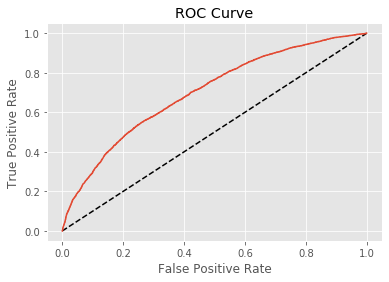

In [75]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [76]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv = 5,scoring = 'roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.7014870287516111


/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

AUC scores computed using 5-fold cross-validation: [0.70163397 0.69688678 0.69419603 0.70068098 0.70837169]


In [77]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Tuned Logistic Regression Parameters: {'C': 3.727593720314938}
Best score is 0.7665668137473182


In [78]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [79]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [80]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)

Text(0, 0.5, 'Feature Importance Score')

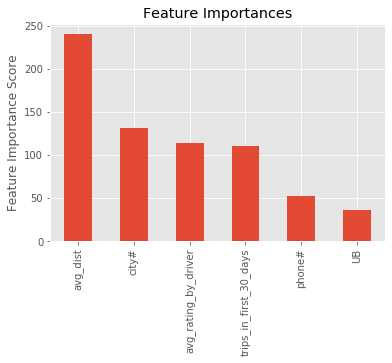

In [81]:
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [82]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.68%


## 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

The goal was to determine the number of active users (24%), identify which continuous (numerical) data was correlated to active users, identify which categorical data was correlated to active users, and then build a model to predict active users. The model accuracy is 78%. I used logistic regression as it is a solid predictor of binary classification. 

The results are that "average distance" is the most important feature to predict active users. This implies that users who use the service for local, smaller trips are most likely to engage frequently and remain active. I would suggest focusing retention campaigns on those local users. If looking for new users, Astapor is the city to focus on as it had the worst rate. A comparison to King's Landing would be beneficial as those users are very active. It also seems that there is a better app experience for iPhone users, so improving the Android app would likely help.